<a href="https://colab.research.google.com/github/rangelokk/Diplom/blob/main/Version_archive/VN/%D0%9F%D0%BE%D0%BA%D0%B5%D0%BC%D0%BE%D0%BD_VggNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Подключаем библиотеки

In [12]:
import kagglehub
import cv2
import tensorflow as tf
import kagglehub
import cv2
import numpy as np
import seaborn as sns
import pandas as pd
import imgaug.augmenters as iaa
import imageio
from PIL import Image
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [2]:
height = 64
width = 64
chanels = 3
input_shape = (height, width, chanels)  # Замените height и width на ваши размеры изображений
num_classes = 7  # Замените на количество классов вашей задачи
num_additional_features = 1  # Например, возраст и пол

### Загрузка данных

In [3]:
# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [00:42<00:00, 131MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [4]:
data = pd.read_csv(path + "/HAM10000_metadata.csv")
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
def read_image(file_path):
  img = cv2.imread(path + '/HAM10000_images_part_2/'+file_path+'.jpg', cv2.IMREAD_COLOR)
  if (img is None):
    img = cv2.imread(path + '/HAM10000_images_part_1/'+file_path+'.jpg', cv2.IMREAD_COLOR)
  return cv2.resize(img, (height, width), interpolation=cv2.INTER_CUBIC)

In [6]:
data['Image'] = data['image_id'].apply(read_image)
data['age'].fillna((data['age'].median()), inplace=True)
data

<ipython-input-6-94a310f2e3e8>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['age'].fillna((data['age'].median()), inplace=True)


,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,"[[[198, 156, 193], [194, 153, 188], [190, 145,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,"[[[25, 12, 21], [27, 14, 23], [42, 25, 36], [7..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,"[[[138, 129, 185], [148, 134, 191], [160, 147,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,"[[[17, 10, 23], [30, 20, 34], [47, 35, 63], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,"[[[118, 95, 140], [139, 114, 159], [163, 134, ..."
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,"[[[163, 152, 165], [156, 142, 159], [142, 123,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,"[[[1, 6, 4], [9, 9, 9], [8, 7, 9], [25, 28, 32..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,"[[[109, 108, 118], [124, 127, 143], [114, 118,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,"[[[145, 128, 156], [129, 109, 154], [157, 134,..."


In [7]:
X_t, Test = train_test_split(data, test_size=0.2, random_state=42)
Train, Val = train_test_split(X_t, test_size=0.25, random_state=42)

In [8]:
Train

,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
482,HAM_0005146,ISIC_0030346,bkl,histo,60.0,male,face,"[[[100, 86, 127], [104, 97, 133], [103, 97, 13..."
7123,HAM_0007477,ISIC_0032007,nv,histo,25.0,male,back,"[[[201, 201, 231], [207, 207, 231], [208, 209,..."
6581,HAM_0007071,ISIC_0030449,nv,follow_up,35.0,female,trunk,"[[[169, 158, 235], [165, 154, 235], [172, 154,..."
6991,HAM_0001767,ISIC_0025812,nv,histo,50.0,female,lower extremity,"[[[165, 145, 164], [168, 146, 165], [165, 142,..."
6333,HAM_0003907,ISIC_0027587,nv,follow_up,60.0,male,upper extremity,"[[[144, 127, 218], [141, 125, 219], [126, 111,..."
...,...,...,...,...,...,...,...,...
9564,HAM_0004197,ISIC_0033467,nv,consensus,40.0,female,unknown,"[[[216, 208, 219], [219, 210, 221], [225, 214,..."
4666,HAM_0002304,ISIC_0024648,nv,follow_up,55.0,female,lower extremity,"[[[198, 172, 247], [198, 172, 245], [198, 174,..."
9382,HAM_0005712,ISIC_0025101,nv,consensus,5.0,female,foot,"[[[183, 146, 180], [184, 146, 182], [185, 144,..."
4070,HAM_0001206,ISIC_0031320,nv,follow_up,55.0,male,abdomen,"[[[165, 143, 225], [166, 140, 226], [164, 144,..."


### Аугментация

<Axes: xlabel='dx', ylabel='percent'>

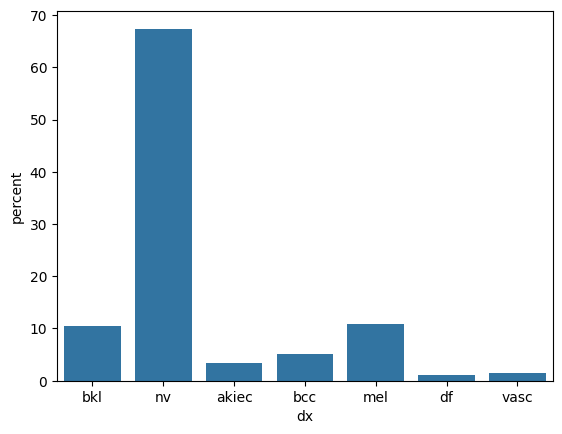

In [9]:
sns.countplot(Train, x="dx", stat="percent")

In [10]:
def Augmentation(dat, apply_dx):
  new_data = pd.DataFrame()
  rotations = [
      iaa.Affine(rotate=90),
      iaa.Affine(rotate=180),
      iaa.Affine(rotate=270)
      ]
  for index, line in dat.iterrows():
    if(line['dx']!='nv'):
      image_np = np.array(line['Image'])
      augmented_images = [(rotation(image=image_np)) for rotation in rotations]
      for aug_image in augmented_images:
        new_line = line.copy()
        new_line['Image'] = Image.fromarray(aug_image)
        new_data = pd.concat([new_data, new_line.to_frame().T], ignore_index=True)
  return new_data

In [13]:
Aug_Data=Augmentation(Train, 'apply_dx')
Aug_Data

,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
0,HAM_0005146,ISIC_0030346,bkl,histo,60.0,male,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
1,HAM_0005146,ISIC_0030346,bkl,histo,60.0,male,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
2,HAM_0005146,ISIC_0030346,bkl,histo,60.0,male,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
3,HAM_0006085,ISIC_0033322,bkl,histo,85.0,female,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
4,HAM_0006085,ISIC_0033322,bkl,histo,85.0,female,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
...,...,...,...,...,...,...,...,...
5872,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
5873,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
5874,HAM_0003435,ISIC_0031350,mel,histo,60.0,male,back,<PIL.Image.Image image mode=RGB size=64x64 at ...
5875,HAM_0003435,ISIC_0031350,mel,histo,60.0,male,back,<PIL.Image.Image image mode=RGB size=64x64 at ...


In [14]:
Train=pd.concat([Train, Aug_Data], ignore_index=True)
Train

,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
0,HAM_0005146,ISIC_0030346,bkl,histo,60.0,male,face,"[[[100, 86, 127], [104, 97, 133], [103, 97, 13..."
1,HAM_0007477,ISIC_0032007,nv,histo,25.0,male,back,"[[[201, 201, 231], [207, 207, 231], [208, 209,..."
2,HAM_0007071,ISIC_0030449,nv,follow_up,35.0,female,trunk,"[[[169, 158, 235], [165, 154, 235], [172, 154,..."
3,HAM_0001767,ISIC_0025812,nv,histo,50.0,female,lower extremity,"[[[165, 145, 164], [168, 146, 165], [165, 142,..."
4,HAM_0003907,ISIC_0027587,nv,follow_up,60.0,male,upper extremity,"[[[144, 127, 218], [141, 125, 219], [126, 111,..."
...,...,...,...,...,...,...,...,...
11881,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
11882,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,<PIL.Image.Image image mode=RGB size=64x64 at ...
11883,HAM_0003435,ISIC_0031350,mel,histo,60.0,male,back,<PIL.Image.Image image mode=RGB size=64x64 at ...
11884,HAM_0003435,ISIC_0031350,mel,histo,60.0,male,back,<PIL.Image.Image image mode=RGB size=64x64 at ...


<Axes: xlabel='dx', ylabel='percent'>

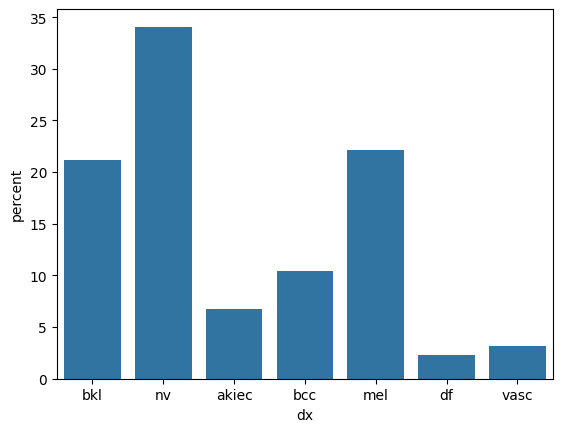

In [15]:
sns.countplot(Train, x="dx", stat="percent")

Run the following code to normalize the dataset and learn about its shapes:

### Сборка данных

In [16]:
def prepare_data(images):
    m = len(images)
    print(m)
    X = np.zeros((m, height, width, chanels), dtype=np.uint8)
    for i, image_file in enumerate(images):
        X[i,:] = image_file
    return X

In [17]:
X_train = prepare_data(Train['Image'])/255.
X_test = prepare_data(Test['Image'])/255.
X_val = prepare_data(Val['Image'])/255.

11886
2003
2003


In [18]:
class_labels = {
    'akiec': 0,
    'bcc': 1,
    'bkl': 2,
    'df': 3,
    'nv': 4,
    'vasc': 5,
    'mel': 6
}
Y_train = to_categorical(Train['dx'].replace(class_labels), num_classes=num_classes)
Y_test = to_categorical(Test['dx'].replace(class_labels), num_classes=num_classes)
Y_val = to_categorical(Val['dx'].replace(class_labels), num_classes=num_classes)

<ipython-input-18-eb22b42d0357>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_train = to_categorical(Train['dx'].replace(class_labels), num_classes=num_classes)
<ipython-input-18-eb22b42d0357>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_test = to_categorical(Test['dx'].replace(class_labels), num_classes=num_classes)
<ipython-input-18-eb22b42d0357>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_object

In [19]:
A_test = (Test['age']/85.).to_numpy().reshape(-1, 1)
A_train = (Train['age']/85.).to_numpy().reshape(-1, 1)
A_val = (Val['age']/85.).to_numpy().reshape(-1, 1)

In [20]:

print ("number of training examples =", X_train.shape[0])
print ("number of test examples =", X_test.shape[0])
print ("X_train shape:", X_train.shape)
print ("Y_train shape:", Y_train.shape)
print ("A_train shape:", A_train.shape)
print ("X_test shape:", X_test.shape)
print ("Y_test shape:", Y_test.shape)
print ("A_test shape:", A_test.shape)
print ("X_val shape:", X_val.shape)
print ("Y_val shape:", Y_val.shape)
print ("A_val shape:", A_val.shape)

number of training examples = 11886
number of test examples = 2003
X_train shape: (11886, 64, 64, 3)
Y_train shape: (11886, 7)
A_train shape: (11886, 1)
X_test shape: (2003, 64, 64, 3)
Y_test shape: (2003, 7)
A_test shape: (2003, 1)
X_val shape: (2003, 64, 64, 3)
Y_val shape: (2003, 7)
A_val shape: (2003, 1)


In [22]:
data['age'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 10015 entries, 0 to 10014
Series name: age
Non-Null Count  Dtype  
--------------  -----  
10015 non-null  float64
dtypes: float64(1)
memory usage: 78.4 KB


###Модель

In [23]:
def create_vgg_model(input_shape, additional_features_shape, classes):
    # Вход для изображений
    image_input = layers.Input(shape=input_shape, name='image_input')

    # Блоки VGG
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(image_input)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Полносвязные слои
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Вход для дополнительных признаков
    additional_input = layers.Input(shape=additional_features_shape, name='additional_input')

    # Объединение входов
    combined = layers.concatenate([x, additional_input])

    # Выходной слой
    output = layers.Dense(classes, activation='softmax')(combined)  # Предполагаем 10 классов

    # Создание модели
    model = models.Model(inputs=[image_input, additional_input], outputs=output)

    return model

In [24]:
# Определяем параметры
additional_features_shape = (num_additional_features, )  # Количество дополнительных признаков

In [25]:
# Создаем модель
model = create_vgg_model(input_shape, additional_features_shape, num_classes)

In [26]:
# Выводим информацию о модели
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │          1,792 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 16, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 8, 8, 256)      │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 8, 8, 512)      │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 512)      │      2,359,808 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 512)      │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 4, 4, 512)      │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 8192)           │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4096)           │     33,558,528 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)    

 Total params: 58,003,790 (221.27 MB)

 Trainable params: 58,003,790 (221.27 MB)

 Non-trainable params: 0 (0.00 B)

###Обучаем модель

In [28]:
Y_train.shape

(6009, 7)

In [19]:
model.output_shape

(None, 7)

In [28]:
# Компилируем модель
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], )
history = model.fit(
    [X_test, A_test],
    Y_test,
    epochs=100,
    batch_size=32,
    validation_data=([X_val, A_val], Y_val)) # дописать фит и не забыть про валидационные данные

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 254ms/step - accuracy: 0.5894 - loss: 1.4906 - val_accuracy: 0.6575 - val_loss: 1.1783
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6774 - loss: 1.1306 - val_accuracy: 0.6575 - val_loss: 1.1451
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.6668 - loss: 1.1425 - val_accuracy: 0.6575 - val_loss: 1.1694
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.6540 - loss: 1.1654 - val_accuracy: 0.6575 - val_loss: 1.1488
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6698 - loss: 1.1281 - val_accuracy: 0.6575 - val_loss: 1.1422
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.6820 - loss: 1.0997 - val_accuracy: 0.6575 - val_loss: 1.1536
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.6812 - loss: 1.0960 - val_accuracy: 0.6575 - val_loss: 1.1499
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.6768 - loss: 1.1056 - val_accuracy: 

###Оцениваем обученную модель

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score

preds = model.evaluate([X_test, A_test], Y_test)

# Прогнозирование на тестовых данных
Y_pred = model.predict([X_test, A_test])
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Вычисление дополнительных метрик
precision = precision_score(Y_true_classes, Y_pred_classes, average='weighted')
recall = recall_score(Y_true_classes, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true_classes, Y_pred_classes, average='weighted')

print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F1 Score = " + str(f1))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6458 - loss: 1.0705
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Loss = 1.0234178304672241
Test Accuracy = 0.6679980158805847
Precision = 0.446221332005985
Recall = 0.6679980029955067
F1 Score = 0.535038208924267


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


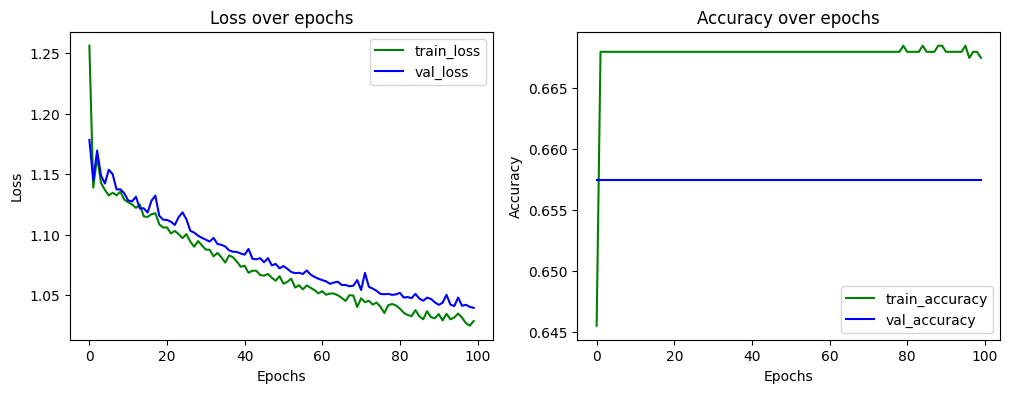

In [30]:
import matplotlib.pyplot as plt

# Построение графиков потерь и точности
def plot_history(history):
    # График потерь
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss', color='green')
    plt.plot(history.history['val_loss'], label='val_loss', color='blue')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_accuracy', color='green')
    plt.plot(history.history['val_accuracy'], label='val_accuracy', color='blue')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Вызов функции для построения графиков
plot_history(history)

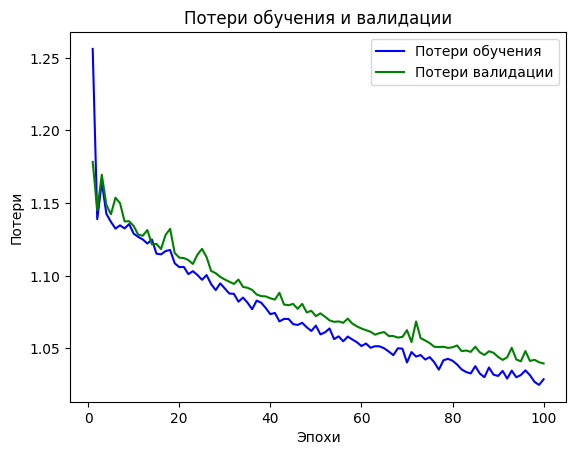

In [32]:
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Потери обучения')
plt.plot(epochs, val_loss, 'g', label='Потери валидации')
plt.title('Потери обучения и валидации')
plt.xlabel('Эпохи') # Полная итерация алгоритма над обучающим набором данных.
plt.ylabel('Потери')
plt.legend()
plt.show()

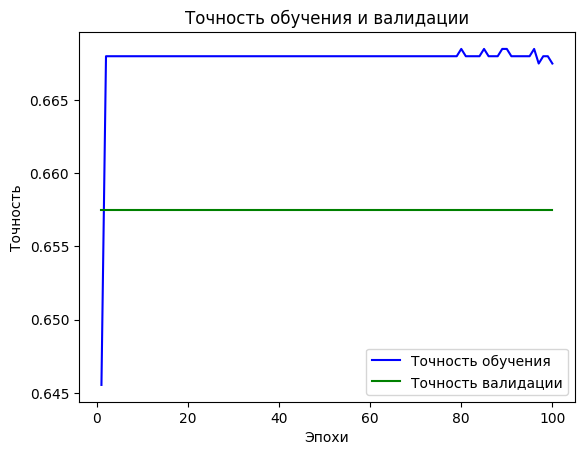

In [31]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Точность обучения')
plt.plot(epochs, val_loss, 'g', label='Точность валидации')
plt.title('Точность обучения и валидации')
plt.xlabel('Эпохи') # Полная итерация алгоритма над обучающим набором данных.
plt.ylabel('Точность')
plt.legend()
plt.show()

In [ ]:
model.summary()